# Azerbaijani Text-to-Speech (TTS) Model Training

This notebook implements a complete end-to-end TTS training pipeline using the Azerbaijani ASR dataset.

**Author:** Automated ML Pipeline  
**Dataset:** LocalDoc/azerbaijani_asr  
**Hardware:** CPU-optimized (laptop-friendly)  

## Overview

This notebook covers:
1. Environment setup and configuration
2. Data loading and exploration
3. Data preprocessing and feature extraction
4. Model training (lightweight TTS architecture)
5. Evaluation and visualization
6. Model persistence and artifacts

## Project Structure

```
azerbaijani_asr_data/
├── charts/          # All visualizations (PNG/SVG)
├── outputs/         # Numerical results, metrics, tables
├── artifacts/       # Trained models and transformers
└── data/            # Source dataset files
```

## 1. Environment Setup and Configuration

In [1]:
# Core libraries
import os
import sys
import json
import pickle
import warnings
from pathlib import Path
from datetime import datetime

# Data handling
import numpy as np
import pandas as pd

# Audio processing
import librosa
import soundfile as sf
from scipy.io import wavfile

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Suppress warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [2]:
# Configuration
class Config:
    """Centralized configuration for reproducibility"""
    
    # Paths
    BASE_DIR = Path(".")
    DATA_DIR = BASE_DIR / "azerbaijani_asr_data" / "data"
    CHARTS_DIR = BASE_DIR / "charts"
    OUTPUTS_DIR = BASE_DIR / "outputs"
    ARTIFACTS_DIR = BASE_DIR / "artifacts"
    
    # Data sampling (for limited hardware)
    SAMPLE_SIZE = 2000  # Number of samples to use from full dataset
    MAX_DURATION = 10.0  # Maximum audio duration in seconds
    MIN_DURATION = 1.0   # Minimum audio duration in seconds
    
    # Audio processing
    SAMPLE_RATE = 16000  # 16kHz as per dataset specs
    N_MELS = 80          # Number of mel filterbanks
    N_FFT = 1024         # FFT window size
    HOP_LENGTH = 256     # Hop length for STFT
    WIN_LENGTH = 1024    # Window length
    FMAX = 8000          # Maximum frequency
    
    # Text processing
    MAX_TEXT_LENGTH = 200  # Maximum character length
    
    # Model training
    BATCH_SIZE = 8
    LEARNING_RATE = 1e-3
    NUM_EPOCHS = 50
    VALIDATION_SPLIT = 0.15
    TEST_SPLIT = 0.15
    
    # Reproducibility
    RANDOM_SEED = 42
    
    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    @classmethod
    def create_directories(cls):
        """Create required directories if they don't exist"""
        for directory in [cls.CHARTS_DIR, cls.OUTPUTS_DIR, cls.ARTIFACTS_DIR]:
            directory.mkdir(exist_ok=True, parents=True)
        print(f"✓ Directory structure verified")
    
    @classmethod
    def save_config(cls):
        """Save configuration to outputs directory"""
        config_dict = {k: str(v) for k, v in cls.__dict__.items() 
                      if not k.startswith('_') and not callable(v)}
        
        config_path = cls.OUTPUTS_DIR / 'config.json'
        with open(config_path, 'w') as f:
            json.dump(config_dict, f, indent=2)
        print(f"✓ Configuration saved to {config_path}")

# Initialize
Config.create_directories()
Config.save_config()

# Set random seeds for reproducibility
np.random.seed(Config.RANDOM_SEED)
torch.manual_seed(Config.RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(Config.RANDOM_SEED)

print(f"\n✓ Configuration loaded")
print(f"  - Device: {Config.DEVICE}")
print(f"  - Sample size: {Config.SAMPLE_SIZE}")
print(f"  - Random seed: {Config.RANDOM_SEED}")

✓ Directory structure verified
✓ Configuration saved to outputs/config.json

✓ Configuration loaded
  - Device: cpu
  - Sample size: 2000
  - Random seed: 42


## 2. Data Loading and Exploration

In [3]:
def load_dataset_sample(data_dir, sample_size=2000, random_seed=42):
    """
    Load a random sample from the Azerbaijani ASR dataset.
    
    Args:
        data_dir: Path to data directory containing parquet files
        sample_size: Number of samples to load
        random_seed: Random seed for reproducibility
        
    Returns:
        DataFrame with sampled data
    """
    print("Loading dataset...")
    
    # Get all parquet files
    parquet_files = list(Path(data_dir).glob('*'))
    parquet_files = [f for f in parquet_files if f.is_file() and not f.name.startswith('.')]
    
    print(f"  Found {len(parquet_files)} parquet files")
    
    # Randomly select files to load
    np.random.seed(random_seed)
    selected_files = np.random.choice(parquet_files, 
                                      size=min(10, len(parquet_files)), 
                                      replace=False)
    
    # Load selected files
    dfs = []
    for file_path in selected_files:
        try:
            df = pd.read_parquet(file_path)
            dfs.append(df)
        except Exception as e:
            print(f"  Warning: Could not load {file_path.name}: {e}")
    
    # Combine and sample
    df_combined = pd.concat(dfs, ignore_index=True)
    
    # Filter by duration
    df_filtered = df_combined[
        (df_combined['duration'] >= Config.MIN_DURATION) & 
        (df_combined['duration'] <= Config.MAX_DURATION)
    ].copy()
    
    # Sample if needed
    if len(df_filtered) > sample_size:
        df_sample = df_filtered.sample(n=sample_size, random_state=random_seed)
    else:
        df_sample = df_filtered
    
    print(f"✓ Loaded {len(df_sample)} samples")
    print(f"  Duration range: {df_sample['duration'].min():.2f}s - {df_sample['duration'].max():.2f}s")
    
    return df_sample.reset_index(drop=True)

# Load data
df = load_dataset_sample(Config.DATA_DIR, Config.SAMPLE_SIZE, Config.RANDOM_SEED)

Loading dataset...
  Found 135 parquet files
✓ Loaded 2000 samples
  Duration range: 1.00s - 9.90s


In [4]:
# Dataset overview
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nShape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())

# Save overview to outputs
overview = {
    'timestamp': datetime.now().isoformat(),
    'total_samples': len(df),
    'columns': list(df.columns),
    'dtypes': df.dtypes.astype(str).to_dict(),
    'missing_values': df.isnull().sum().to_dict()
}

with open(Config.OUTPUTS_DIR / 'dataset_overview.json', 'w') as f:
    json.dump(overview, f, indent=2)

print(f"\n✓ Overview saved to {Config.OUTPUTS_DIR / 'dataset_overview.json'}")

DATASET OVERVIEW

Shape: (2000, 4)
Columns: ['audio', 'text', 'duration', 'audio_file']

Data types:
audio          object
text           object
duration      float64
audio_file     object
dtype: object

Missing values:
audio         0
text          0
duration      0
audio_file    0
dtype: int64

✓ Overview saved to outputs/dataset_overview.json


In [5]:
# Text statistics
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

text_stats = df[['text_length', 'word_count', 'duration']].describe()
print("\n" + "="*80)
print("TEXT AND DURATION STATISTICS")
print("="*80)
print(text_stats)

# Save to outputs
text_stats.to_csv(Config.OUTPUTS_DIR / 'text_statistics.csv')
print(f"\n✓ Statistics saved to {Config.OUTPUTS_DIR / 'text_statistics.csv'}")


TEXT AND DURATION STATISTICS
       text_length   word_count     duration
count  2000.000000  2000.000000  2000.000000
mean     52.897500     7.491000     3.158466
std      29.673191     4.009359     1.860847
min       4.000000     1.000000     1.000000
25%      30.000000     5.000000     1.697500
50%      45.000000     6.500000     2.620000
75%      68.000000    10.000000     4.160000
max     181.000000    25.000000     9.896000

✓ Statistics saved to outputs/text_statistics.csv


In [6]:
# Sample texts
print("\n" + "="*80)
print("SAMPLE TEXTS")
print("="*80)
for i, row in df.head(10).iterrows():
    print(f"\n{i+1}. [{row['duration']:.2f}s] {row['text']}")
    
# Save sample texts
sample_texts = df.head(20)[['text', 'duration', 'text_length']].copy()
sample_texts.to_csv(Config.OUTPUTS_DIR / 'sample_texts.csv', index=False)
print(f"\n✓ Sample texts saved to {Config.OUTPUTS_DIR / 'sample_texts.csv'}")


SAMPLE TEXTS

1. [2.65s] Eradan əvvəl üçüncü-ikinci minilliklər.

2. [1.25s] Yarpaqlar titrəşdi.

3. [7.89s] Söylədiklərinizi təsdiq eləyirəm, lakin düşmən vətənin üstünə hücum elədikdə döşlərini verib onu müdafiə eləyən kimdir?

4. [4.03s] Nizənin ipini kütükdən açıb balığın qəlsəmələrindən keçirtdi.

5. [3.02s] Yalnız axşamdan səhərə asudə gəzə bilərik, anladın?

6. [4.50s] Dunyanın sırf zengin olduğu için Pietr ile evlenme teklifini kabul ettiğini biliyorum.

7. [2.61s] Paranızı Sonya'nın çaldığından nasıl bu kadar emin olabiliyorsunuz ha?

8. [4.66s] Hərəkətlərinizin də onları əks etdirərək istəklərinizə qarşı gəlmədiyinə əmin olun.

9. [1.77s] Siz onun en yakın arkadaşısınız.

10. [1.65s] Yarpaqlar artıq xışıldaşmırdı.

✓ Sample texts saved to outputs/sample_texts.csv


✓ Exploration charts saved to charts/data_exploration.png


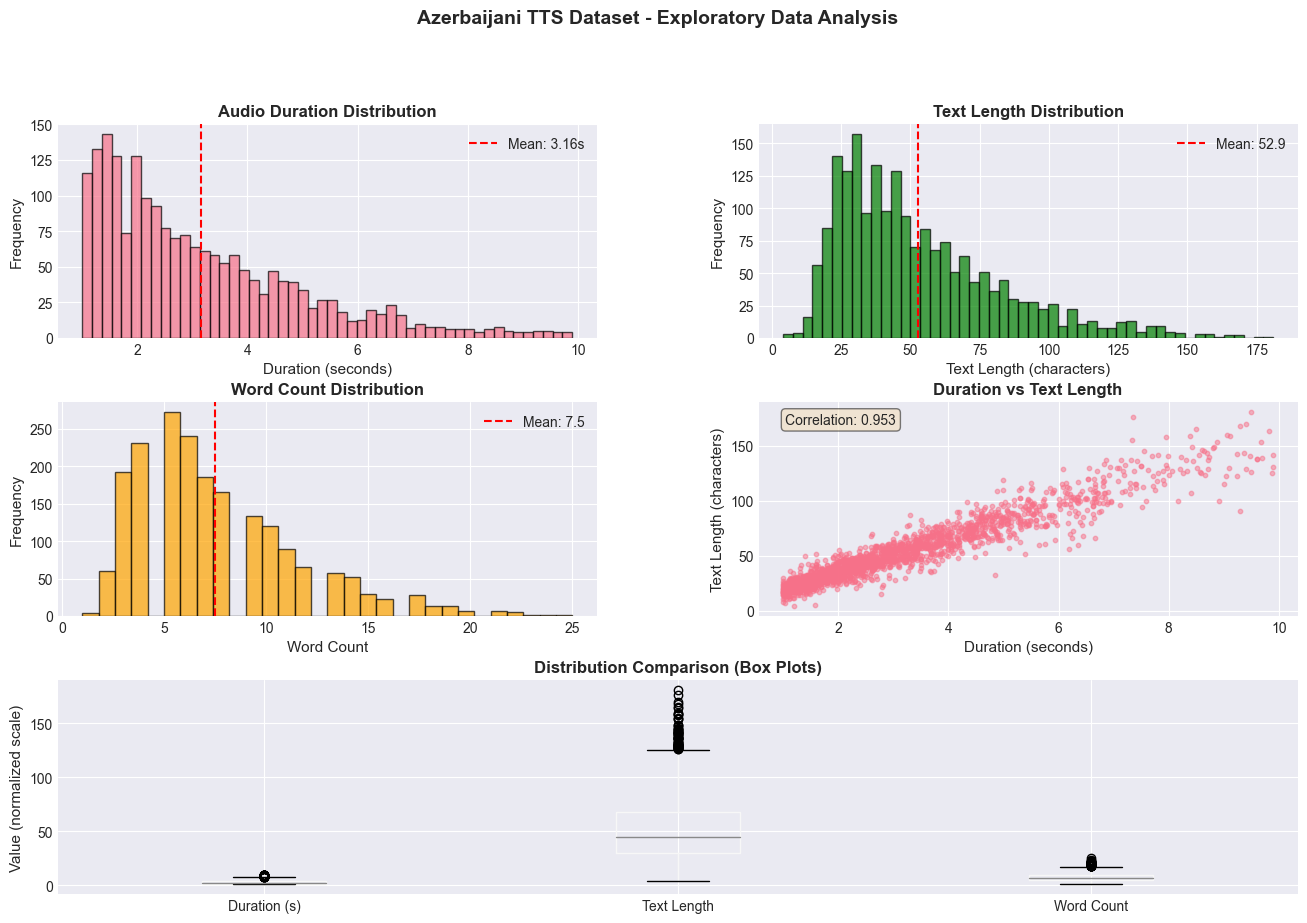

In [7]:
# Visualization: Distribution analysis
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.3)

# Duration distribution
ax1 = fig.add_subplot(gs[0, 0])
df['duration'].hist(bins=50, ax=ax1, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Duration (seconds)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Audio Duration Distribution', fontsize=12, fontweight='bold')
ax1.axvline(df['duration'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["duration"].mean():.2f}s')
ax1.legend()

# Text length distribution
ax2 = fig.add_subplot(gs[0, 1])
df['text_length'].hist(bins=50, ax=ax2, edgecolor='black', alpha=0.7, color='green')
ax2.set_xlabel('Text Length (characters)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Text Length Distribution', fontsize=12, fontweight='bold')
ax2.axvline(df['text_length'].mean(), color='red', linestyle='--',
            label=f'Mean: {df["text_length"].mean():.1f}')
ax2.legend()

# Word count distribution
ax3 = fig.add_subplot(gs[1, 0])
df['word_count'].hist(bins=30, ax=ax3, edgecolor='black', alpha=0.7, color='orange')
ax3.set_xlabel('Word Count', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Word Count Distribution', fontsize=12, fontweight='bold')
ax3.axvline(df['word_count'].mean(), color='red', linestyle='--',
            label=f'Mean: {df["word_count"].mean():.1f}')
ax3.legend()

# Duration vs Text Length
ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(df['duration'], df['text_length'], alpha=0.5, s=10)
ax4.set_xlabel('Duration (seconds)', fontsize=11)
ax4.set_ylabel('Text Length (characters)', fontsize=11)
ax4.set_title('Duration vs Text Length', fontsize=12, fontweight='bold')

# Correlation coefficient
corr = df['duration'].corr(df['text_length'])
ax4.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
         transform=ax4.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Box plots
ax5 = fig.add_subplot(gs[2, :])
df[['duration', 'text_length', 'word_count']].boxplot(ax=ax5)
ax5.set_ylabel('Value (normalized scale)', fontsize=11)
ax5.set_title('Distribution Comparison (Box Plots)', fontsize=12, fontweight='bold')
ax5.set_xticklabels(['Duration (s)', 'Text Length', 'Word Count'])

plt.suptitle('Azerbaijani TTS Dataset - Exploratory Data Analysis', 
             fontsize=14, fontweight='bold', y=0.995)

# Save figure
chart_path = Config.CHARTS_DIR / 'data_exploration.png'
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
print(f"✓ Exploration charts saved to {chart_path}")
plt.show()

## 3. Data Preprocessing and Feature Extraction

In [8]:
# Character-level text encoding
class CharacterEncoder:
    """Encode and decode text at character level"""
    
    def __init__(self):
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.vocab_size = 0
        
    def fit(self, texts):
        """Build vocabulary from texts"""
        # Get all unique characters
        all_chars = set(''.join(texts))
        
        # Add special tokens
        special_tokens = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
        
        # Build mappings
        vocab = special_tokens + sorted(list(all_chars))
        self.char_to_idx = {char: idx for idx, char in enumerate(vocab)}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        self.vocab_size = len(vocab)
        
        print(f"✓ Vocabulary built: {self.vocab_size} unique characters")
        return self
    
    def encode(self, text, max_length=None):
        """Convert text to indices"""
        indices = [self.char_to_idx.get(char, self.char_to_idx['<UNK>']) 
                  for char in text]
        
        # Add EOS token
        indices.append(self.char_to_idx['<EOS>'])
        
        # Pad if needed
        if max_length:
            if len(indices) < max_length:
                indices += [self.char_to_idx['<PAD>']] * (max_length - len(indices))
            else:
                indices = indices[:max_length]
        
        return indices
    
    def decode(self, indices):
        """Convert indices back to text"""
        chars = []
        for idx in indices:
            if idx == self.char_to_idx['<EOS>']:
                break
            if idx != self.char_to_idx['<PAD>']:
                chars.append(self.idx_to_char.get(idx, '<UNK>'))
        return ''.join(chars)

# Build character encoder
char_encoder = CharacterEncoder()
char_encoder.fit(df['text'].tolist())

# Save encoder
with open(Config.ARTIFACTS_DIR / 'char_encoder.pkl', 'wb') as f:
    pickle.dump(char_encoder, f)
print(f"✓ Character encoder saved to {Config.ARTIFACTS_DIR / 'char_encoder.pkl'}")

# Test encoding/decoding
test_text = df['text'].iloc[0]
encoded = char_encoder.encode(test_text)
decoded = char_encoder.decode(encoded)
print(f"\nTest encoding:")
print(f"  Original: {test_text}")
print(f"  Encoded length: {len(encoded)}")
print(f"  Decoded: {decoded}")
print(f"  Match: {test_text == decoded}")

✓ Vocabulary built: 124 unique characters
✓ Character encoder saved to artifacts/char_encoder.pkl

Test encoding:
  Original: Eradan əvvəl üçüncü-ikinci minilliklər.
  Encoded length: 40
  Decoded: Eradan əvvəl üçüncü-ikinci minilliklər.
  Match: True


In [9]:
def extract_mel_spectrogram(audio_bytes, sr=16000, n_mels=80, n_fft=1024, 
                           hop_length=256, fmax=8000):
    """
    Extract mel-spectrogram from audio bytes.
    
    Args:
        audio_bytes: Audio data in bytes
        sr: Sample rate
        n_mels: Number of mel bands
        n_fft: FFT window size
        hop_length: Hop length
        fmax: Maximum frequency
        
    Returns:
        Mel spectrogram (n_mels x time)
    """
    import io
    import wave
    
    # Load audio from bytes
    with wave.open(io.BytesIO(audio_bytes), 'rb') as wav_file:
        audio_data = wav_file.readframes(wav_file.getnframes())
        audio_array = np.frombuffer(audio_data, dtype=np.int16)
    
    # Convert to float
    audio_float = audio_array.astype(np.float32) / 32768.0
    
    # Extract mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio_float,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length,
        fmax=fmax
    )
    
    # Convert to log scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    return mel_spec_db

# Test mel spectrogram extraction
print("Testing mel-spectrogram extraction...")
test_audio = df['audio'].iloc[0]['bytes']
test_mel = extract_mel_spectrogram(test_audio, 
                                   sr=Config.SAMPLE_RATE,
                                   n_mels=Config.N_MELS,
                                   n_fft=Config.N_FFT,
                                   hop_length=Config.HOP_LENGTH,
                                   fmax=Config.FMAX)

print(f"✓ Mel-spectrogram shape: {test_mel.shape}")
print(f"  - Mel bands: {test_mel.shape[0]}")
print(f"  - Time frames: {test_mel.shape[1]}")
print(f"  - Value range: [{test_mel.min():.2f}, {test_mel.max():.2f}] dB")

Testing mel-spectrogram extraction...
✓ Mel-spectrogram shape: (80, 166)
  - Mel bands: 80
  - Time frames: 166
  - Value range: [-80.00, 0.00] dB


✓ Mel spectrogram samples saved to charts/sample_mel_spectrograms.png


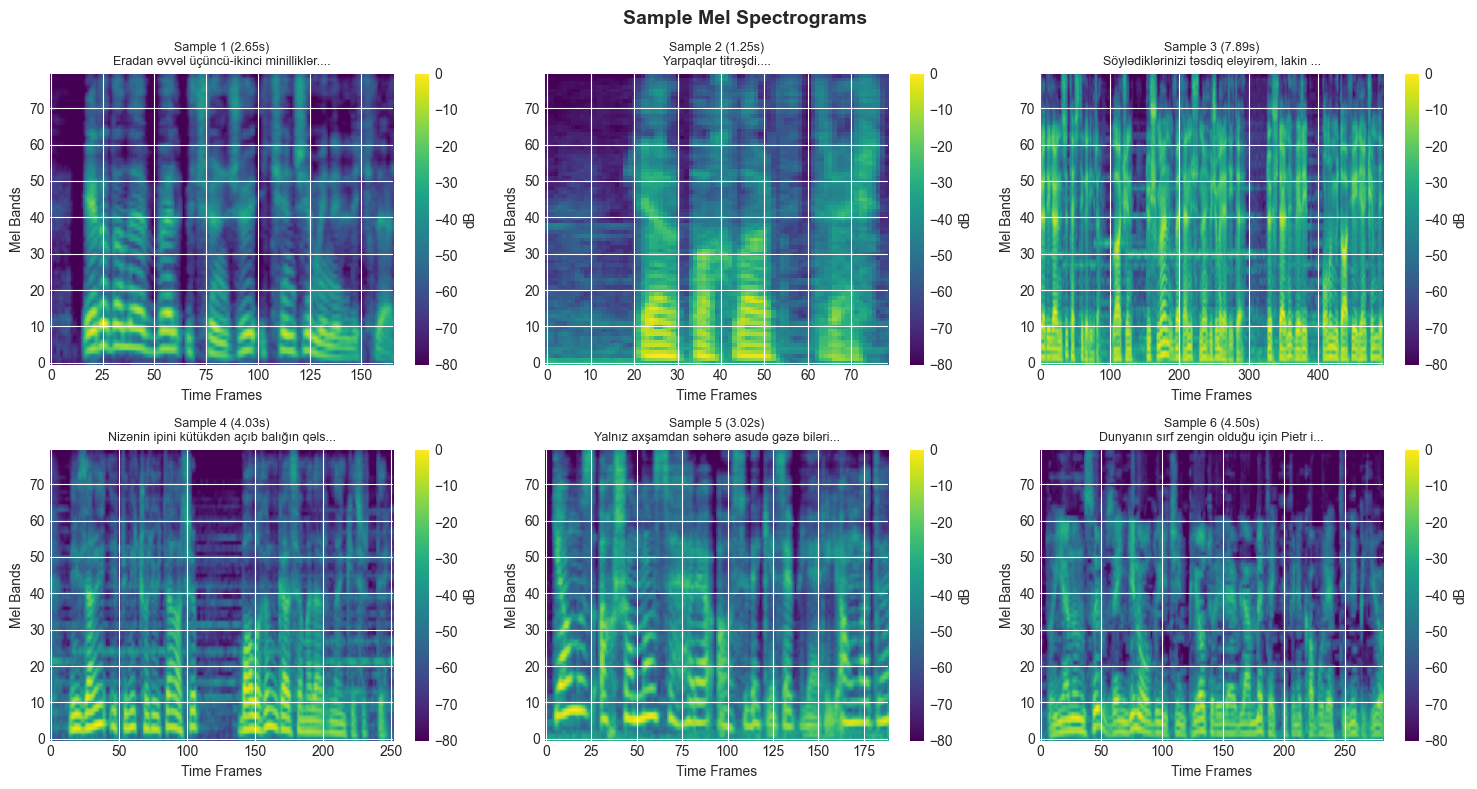

In [10]:
# Visualize sample mel spectrograms
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx in range(6):
    audio_bytes = df['audio'].iloc[idx]['bytes']
    text = df['text'].iloc[idx]
    duration = df['duration'].iloc[idx]
    
    mel_spec = extract_mel_spectrogram(audio_bytes,
                                       sr=Config.SAMPLE_RATE,
                                       n_mels=Config.N_MELS,
                                       n_fft=Config.N_FFT,
                                       hop_length=Config.HOP_LENGTH,
                                       fmax=Config.FMAX)
    
    im = axes[idx].imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
    axes[idx].set_xlabel('Time Frames')
    axes[idx].set_ylabel('Mel Bands')
    axes[idx].set_title(f'Sample {idx+1} ({duration:.2f}s)\n{text[:40]}...', fontsize=9)
    plt.colorbar(im, ax=axes[idx], label='dB')

plt.suptitle('Sample Mel Spectrograms', fontsize=14, fontweight='bold')
plt.tight_layout()

chart_path = Config.CHARTS_DIR / 'sample_mel_spectrograms.png'
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
print(f"✓ Mel spectrogram samples saved to {chart_path}")
plt.show()

In [11]:
# Custom Dataset class for TTS
class TTSDataset(Dataset):
    """PyTorch Dataset for Text-to-Speech"""
    
    def __init__(self, dataframe, char_encoder, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.char_encoder = char_encoder
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Extract text
        text = row['text']
        text_encoded = self.char_encoder.encode(text, max_length=Config.MAX_TEXT_LENGTH)
        text_tensor = torch.tensor(text_encoded, dtype=torch.long)
        
        # Extract mel spectrogram
        audio_bytes = row['audio']['bytes']
        mel_spec = extract_mel_spectrogram(
            audio_bytes,
            sr=Config.SAMPLE_RATE,
            n_mels=Config.N_MELS,
            n_fft=Config.N_FFT,
            hop_length=Config.HOP_LENGTH,
            fmax=Config.FMAX
        )
        
        mel_tensor = torch.tensor(mel_spec, dtype=torch.float32)
        
        # Apply transforms if any
        if self.transform:
            mel_tensor = self.transform(mel_tensor)
        
        return {
            'text': text_tensor,
            'mel': mel_tensor,
            'text_length': len(text),
            'mel_length': mel_tensor.shape[1],
            'original_text': text
        }

print("✓ TTSDataset class defined")

✓ TTSDataset class defined


In [12]:
# Split data into train, validation, and test sets
print("Splitting dataset...")

# First split: separate test set
train_val_df, test_df = train_test_split(
    df, 
    test_size=Config.TEST_SPLIT, 
    random_state=Config.RANDOM_SEED,
    shuffle=True
)

# Second split: separate validation from training
train_df, val_df = train_test_split(
    train_val_df,
    test_size=Config.VALIDATION_SPLIT / (1 - Config.TEST_SPLIT),
    random_state=Config.RANDOM_SEED,
    shuffle=True
)

print(f"✓ Data split completed:")
print(f"  - Training: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"  - Validation: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"  - Test: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")

# Save split information
split_info = {
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df),
    'train_pct': len(train_df) / len(df) * 100,
    'val_pct': len(val_df) / len(df) * 100,
    'test_pct': len(test_df) / len(df) * 100
}

with open(Config.OUTPUTS_DIR / 'data_split.json', 'w') as f:
    json.dump(split_info, f, indent=2)

print(f"\n✓ Split information saved to {Config.OUTPUTS_DIR / 'data_split.json'}")

Splitting dataset...
✓ Data split completed:
  - Training: 1400 samples (70.0%)
  - Validation: 300 samples (15.0%)
  - Test: 300 samples (15.0%)

✓ Split information saved to outputs/data_split.json


In [13]:
# Create datasets and dataloaders
train_dataset = TTSDataset(train_df, char_encoder)
val_dataset = TTSDataset(val_df, char_encoder)
test_dataset = TTSDataset(test_df, char_encoder)

print(f"✓ Datasets created:")
print(f"  - Train dataset: {len(train_dataset)} samples")
print(f"  - Validation dataset: {len(val_dataset)} samples")
print(f"  - Test dataset: {len(test_dataset)} samples")

# Test dataset
sample = train_dataset[0]
print(f"\nSample data point:")
print(f"  - Text tensor shape: {sample['text'].shape}")
print(f"  - Mel tensor shape: {sample['mel'].shape}")
print(f"  - Original text: {sample['original_text']}")

✓ Datasets created:
  - Train dataset: 1400 samples
  - Validation dataset: 300 samples
  - Test dataset: 300 samples

Sample data point:
  - Text tensor shape: torch.Size([200])
  - Mel tensor shape: torch.Size([80, 123])
  - Original text: Biz ona istənilən adı verə bilərik.


## 4. Model Architecture and Training

In [14]:
# Lightweight TTS Model (Sequence-to-Sequence with Attention)
class TTSEncoder(nn.Module):
    """Text encoder for TTS"""
    
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, num_layers=2):
        super(TTSEncoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers, 
            batch_first=True,
            bidirectional=True
        )
        
    def forward(self, x):
        # x: (batch, seq_len)
        embedded = self.embedding(x)  # (batch, seq_len, embedding_dim)
        outputs, (hidden, cell) = self.lstm(embedded)
        return outputs  # (batch, seq_len, hidden_dim*2)


class Attention(nn.Module):
    """Attention mechanism"""
    
    def __init__(self, encoder_dim, decoder_dim, attention_dim=128):
        super(Attention, self).__init__()
        
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        
    def forward(self, encoder_out, decoder_hidden):
        # encoder_out: (batch, seq_len, encoder_dim)
        # decoder_hidden: (batch, decoder_dim)
        
        att1 = self.encoder_att(encoder_out)  # (batch, seq_len, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch, attention_dim)
        att = self.full_att(torch.tanh(att1 + att2.unsqueeze(1)))  # (batch, seq_len, 1)
        alpha = torch.softmax(att, dim=1)  # (batch, seq_len, 1)
        context = (encoder_out * alpha).sum(dim=1)  # (batch, encoder_dim)
        
        return context, alpha


class TTSDecoder(nn.Module):
    """Mel spectrogram decoder"""
    
    def __init__(self, encoder_dim, decoder_dim=512, n_mels=80, num_layers=2):
        super(TTSDecoder, self).__init__()
        
        self.attention = Attention(encoder_dim, decoder_dim)
        self.lstm = nn.LSTM(
            encoder_dim + n_mels,
            decoder_dim,
            num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(decoder_dim, n_mels)
        
    def forward(self, encoder_out, mel_input, hidden=None):
        # encoder_out: (batch, seq_len, encoder_dim)
        # mel_input: (batch, n_mels)
        
        if hidden is None:
            batch_size = encoder_out.size(0)
            hidden = (torch.zeros(2, batch_size, 512).to(encoder_out.device),
                     torch.zeros(2, batch_size, 512).to(encoder_out.device))
        
        # Get context from attention
        context, alpha = self.attention(encoder_out, hidden[0][-1])
        
        # Concatenate context and previous mel frame
        decoder_input = torch.cat([context, mel_input], dim=1).unsqueeze(1)
        
        # LSTM step
        output, hidden = self.lstm(decoder_input, hidden)
        
        # Predict mel frame
        mel_frame = self.fc(output.squeeze(1))
        
        return mel_frame, hidden, alpha


class SimpleTTS(nn.Module):
    """Simple TTS model combining encoder and decoder"""
    
    def __init__(self, vocab_size, n_mels=80):
        super(SimpleTTS, self).__init__()
        
        self.encoder = TTSEncoder(vocab_size, embedding_dim=256, hidden_dim=256, num_layers=2)
        self.decoder = TTSDecoder(encoder_dim=512, decoder_dim=512, n_mels=n_mels, num_layers=2)
        self.n_mels = n_mels
        
    def forward(self, text, mel_target=None, max_len=500):
        batch_size = text.size(0)
        
        # Encode text
        encoder_out = self.encoder(text)
        
        # Initialize
        mel_outputs = []
        mel_input = torch.zeros(batch_size, self.n_mels).to(text.device)
        hidden = None
        
        # Determine target length
        if mel_target is not None:
            target_len = mel_target.size(2)
        else:
            target_len = max_len
        
        # Decode step by step
        for t in range(target_len):
            mel_frame, hidden, alpha = self.decoder(encoder_out, mel_input, hidden)
            mel_outputs.append(mel_frame.unsqueeze(2))
            
            # Teacher forcing during training
            if mel_target is not None and t < target_len - 1:
                mel_input = mel_target[:, :, t]
            else:
                mel_input = mel_frame
        
        # Stack outputs
        mel_outputs = torch.cat(mel_outputs, dim=2)  # (batch, n_mels, time)
        
        return mel_outputs


# Initialize model
model = SimpleTTS(vocab_size=char_encoder.vocab_size, n_mels=Config.N_MELS)
model = model.to(Config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✓ TTS Model initialized")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")
print(f"  - Device: {Config.DEVICE}")

# Save model info
model_info = {
    'architecture': 'Seq2Seq with Attention',
    'total_params': total_params,
    'trainable_params': trainable_params,
    'vocab_size': char_encoder.vocab_size,
    'n_mels': Config.N_MELS,
    'device': str(Config.DEVICE)
}

with open(Config.OUTPUTS_DIR / 'model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"\n✓ Model info saved to {Config.OUTPUTS_DIR / 'model_info.json'}")

✓ TTS Model initialized
  - Total parameters: 7,200,209
  - Trainable parameters: 7,200,209
  - Device: cpu

✓ Model info saved to outputs/model_info.json


In [15]:
# Custom collate function for variable-length sequences
def collate_fn(batch):
    """Collate function to handle variable-length sequences"""
    
    # Sort by mel length (descending) for efficient packing
    batch = sorted(batch, key=lambda x: x['mel_length'], reverse=True)
    
    # Get max lengths
    max_text_len = max(item['text'].size(0) for item in batch)
    max_mel_len = max(item['mel'].size(1) for item in batch)
    
    # Pad sequences
    texts = []
    mels = []
    
    for item in batch:
        # Pad text
        text = item['text']
        text_padded = torch.nn.functional.pad(
            text, (0, max_text_len - text.size(0)), value=0
        )
        texts.append(text_padded)
        
        # Pad mel
        mel = item['mel']
        mel_padded = torch.nn.functional.pad(
            mel, (0, max_mel_len - mel.size(1)), value=0
        )
        mels.append(mel_padded)
    
    return {
        'text': torch.stack(texts),
        'mel': torch.stack(mels),
        'text_lengths': torch.tensor([item['text_length'] for item in batch]),
        'mel_lengths': torch.tensor([item['mel_length'] for item in batch])
    }

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0  # Set to 0 for compatibility
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

print(f"✓ DataLoaders created:")
print(f"  - Train batches: {len(train_loader)}")
print(f"  - Validation batches: {len(val_loader)}")

# Test dataloader
sample_batch = next(iter(train_loader))
print(f"\nSample batch:")
print(f"  - Text shape: {sample_batch['text'].shape}")
print(f"  - Mel shape: {sample_batch['mel'].shape}")

✓ DataLoaders created:
  - Train batches: 175
  - Validation batches: 38

Sample batch:
  - Text shape: torch.Size([8, 200])
  - Mel shape: torch.Size([8, 80, 310])


In [17]:
# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("✓ Training setup complete")
print(f"  - Loss function: MSE")
print(f"  - Optimizer: Adam")
print(f"  - Learning rate: {Config.LEARNING_RATE}")
print(f"  - Scheduler: ReduceLROnPlateau")

✓ Training setup complete
  - Loss function: MSE
  - Optimizer: Adam
  - Learning rate: 0.001
  - Scheduler: ReduceLROnPlateau


In [18]:
# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for batch_idx, batch in enumerate(dataloader):
        text = batch['text'].to(device)
        mel_target = batch['mel'].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        mel_output = model(text, mel_target)
        
        # Calculate loss
        loss = criterion(mel_output, mel_target)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss


def validate(model, dataloader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            text = batch['text'].to(device)
            mel_target = batch['mel'].to(device)
            
            mel_output = model(text, mel_target)
            loss = criterion(mel_output, mel_target)
            
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

print("✓ Training functions defined")

✓ Training functions defined


In [19]:
# Training loop
print(f"Starting training for {Config.NUM_EPOCHS} epochs...")
print("=" * 80)

train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(Config.NUM_EPOCHS):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, Config.DEVICE)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, Config.DEVICE)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Print progress
    print(f"Epoch {epoch+1}/{Config.NUM_EPOCHS} - "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, Config.ARTIFACTS_DIR / 'best_model.pt')
        print(f"  ✓ Best model saved (val_loss: {val_loss:.4f})")
    
    # Early stopping check (optional)
    if epoch > 20 and val_loss > min(val_losses[-10:]):
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\n" + "=" * 80)
print(f"✓ Training completed")
print(f"  - Best validation loss: {best_val_loss:.4f}")
print(f"  - Final training loss: {train_losses[-1]:.4f}")

Starting training for 50 epochs...
Epoch 1/50 - Train Loss: 331.4933, Val Loss: 78.4056
  ✓ Best model saved (val_loss: 78.4056)
Epoch 2/50 - Train Loss: 70.5742, Val Loss: 64.4147
  ✓ Best model saved (val_loss: 64.4147)
Epoch 3/50 - Train Loss: 62.7279, Val Loss: 61.7102
  ✓ Best model saved (val_loss: 61.7102)
Epoch 4/50 - Train Loss: 61.7715, Val Loss: 59.4691
  ✓ Best model saved (val_loss: 59.4691)
Epoch 5/50 - Train Loss: 57.8577, Val Loss: 57.1565
  ✓ Best model saved (val_loss: 57.1565)
Epoch 6/50 - Train Loss: 56.2959, Val Loss: 54.1601
  ✓ Best model saved (val_loss: 54.1601)
Epoch 7/50 - Train Loss: 54.3696, Val Loss: 51.6831
  ✓ Best model saved (val_loss: 51.6831)
Epoch 8/50 - Train Loss: 51.1305, Val Loss: 49.4082
  ✓ Best model saved (val_loss: 49.4082)
Epoch 9/50 - Train Loss: 48.3288, Val Loss: 48.0559
  ✓ Best model saved (val_loss: 48.0559)
Epoch 10/50 - Train Loss: 48.3206, Val Loss: 46.9622
  ✓ Best model saved (val_loss: 46.9622)
Epoch 11/50 - Train Loss: 47.4129

In [21]:
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'config': {
        'SAMPLE_SIZE': Config.SAMPLE_SIZE,
        'BATCH_SIZE': Config.BATCH_SIZE,
        'LEARNING_RATE': Config.LEARNING_RATE,
        'NUM_EPOCHS': Config.NUM_EPOCHS,
        'N_MELS': Config.N_MELS,
        'SAMPLE_RATE': Config.SAMPLE_RATE
    }
}, Config.ARTIFACTS_DIR / 'final_model.pt')

print(f"✓ Final model saved to {Config.ARTIFACTS_DIR / 'final_model.pt'}")

# Save training history
history_df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train_loss': train_losses,
    'val_loss': val_losses
})

history_df.to_csv(Config.OUTPUTS_DIR / 'training_history.csv', index=False)
print(f"✓ Training history saved to {Config.OUTPUTS_DIR / 'training_history.csv'}")

✓ Final model saved to artifacts/final_model.pt
✓ Training history saved to outputs/training_history.csv


## 5. Evaluation and Visualization

✓ Training curves saved to charts/training_curves.png


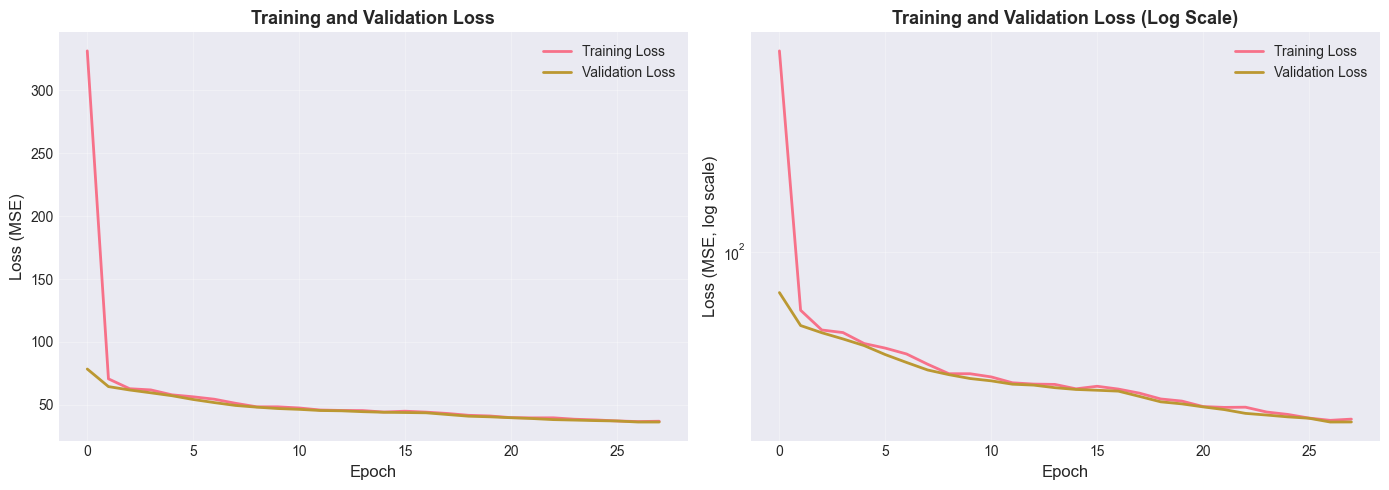

In [22]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss comparison (log scale)
axes[1].semilogy(train_losses, label='Training Loss', linewidth=2)
axes[1].semilogy(val_losses, label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss (MSE, log scale)', fontsize=12)
axes[1].set_title('Training and Validation Loss (Log Scale)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
chart_path = Config.CHARTS_DIR / 'training_curves.png'
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
print(f"✓ Training curves saved to {chart_path}")
plt.show()

In [23]:
# Load best model for evaluation
checkpoint = torch.load(Config.ARTIFACTS_DIR / 'best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Best model loaded (from epoch {checkpoint['epoch'] + 1})")
print(f"  - Validation loss: {checkpoint['val_loss']:.4f}")

✓ Best model loaded (from epoch 27)
  - Validation loss: 36.2280


In [24]:
# Generate predictions on test set
print("Generating predictions on test set...")

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

predictions = []
targets = []
test_losses = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        text = batch['text'].to(Config.DEVICE)
        mel_target = batch['mel'].to(Config.DEVICE)
        
        mel_output = model(text, mel_target)
        
        loss = criterion(mel_output, mel_target)
        test_losses.append(loss.item())
        
        predictions.append(mel_output.cpu().numpy())
        targets.append(mel_target.cpu().numpy())

avg_test_loss = np.mean(test_losses)
std_test_loss = np.std(test_losses)

print(f"✓ Test evaluation completed")
print(f"  - Average test loss: {avg_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"  - Min test loss: {min(test_losses):.4f}")
print(f"  - Max test loss: {max(test_losses):.4f}")

# Save test metrics
test_metrics = {
    'avg_test_loss': float(avg_test_loss),
    'std_test_loss': float(std_test_loss),
    'min_test_loss': float(min(test_losses)),
    'max_test_loss': float(max(test_losses)),
    'num_test_samples': len(test_losses)
}

with open(Config.OUTPUTS_DIR / 'test_metrics.json', 'w') as f:
    json.dump(test_metrics, f, indent=2)

print(f"\n✓ Test metrics saved to {Config.OUTPUTS_DIR / 'test_metrics.json'}")

Generating predictions on test set...
✓ Test evaluation completed
  - Average test loss: 55.6141 ± 12.6530
  - Min test loss: 28.3879
  - Max test loss: 98.7196

✓ Test metrics saved to outputs/test_metrics.json


✓ Prediction comparison saved to charts/predictions_comparison.png


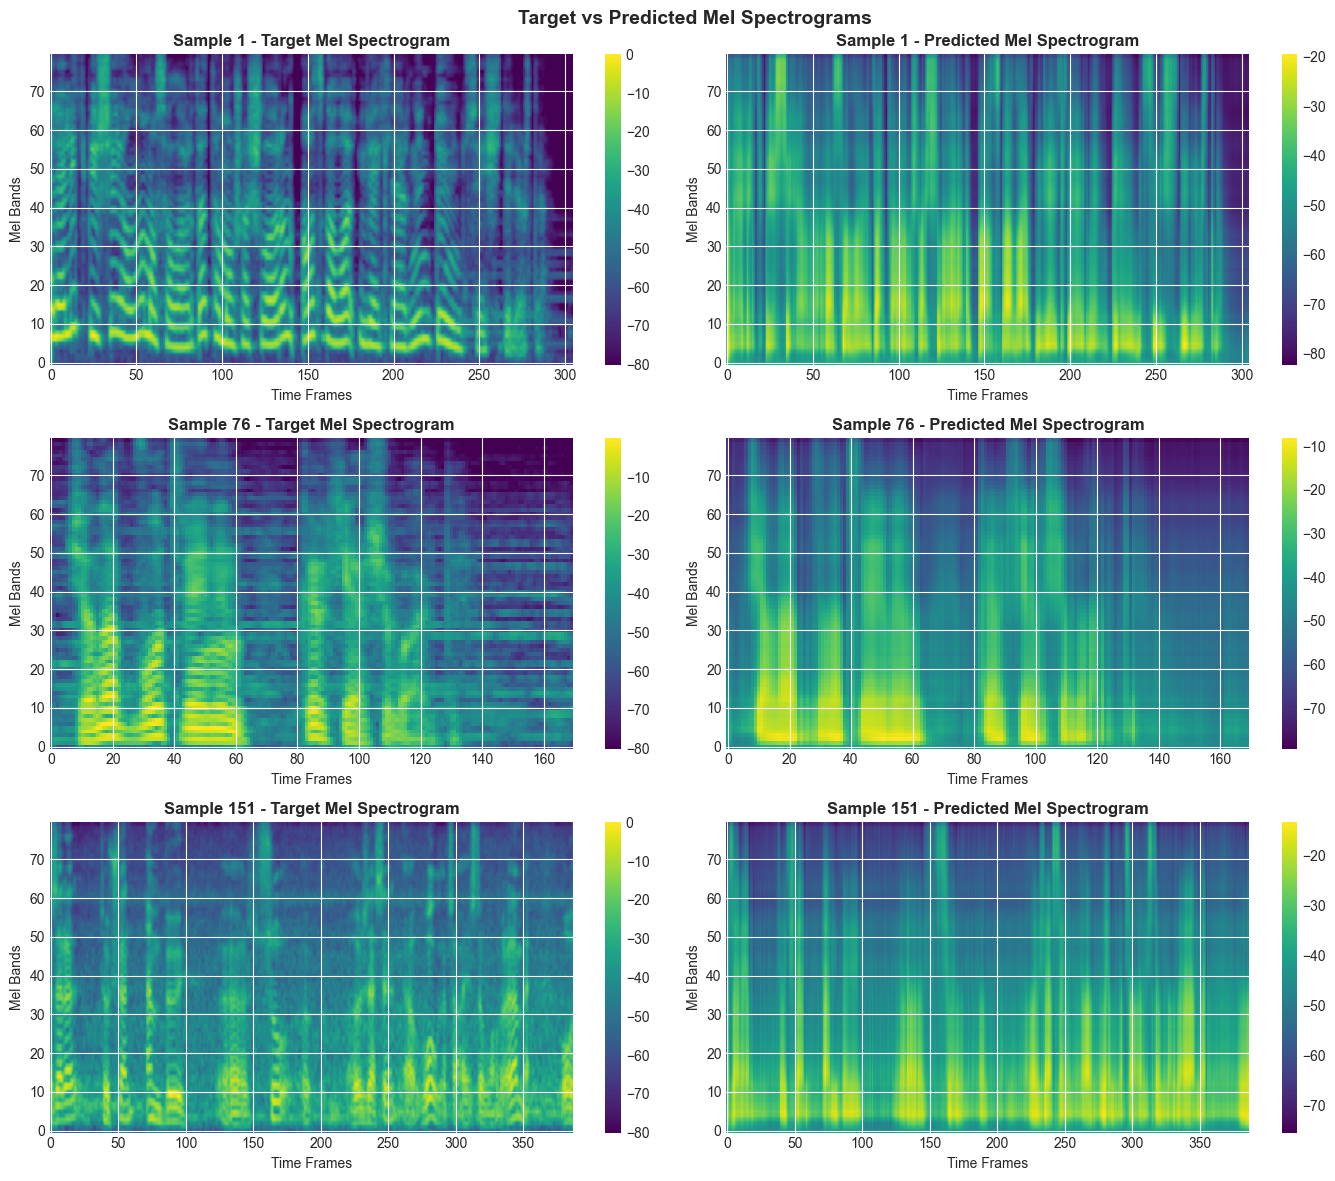

In [25]:
# Visualize sample predictions
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

sample_indices = [0, len(predictions)//4, len(predictions)//2]

for idx, sample_idx in enumerate(sample_indices):
    pred = predictions[sample_idx][0]
    target = targets[sample_idx][0]
    
    # Target
    im1 = axes[idx, 0].imshow(target, aspect='auto', origin='lower', cmap='viridis')
    axes[idx, 0].set_title(f'Sample {sample_idx+1} - Target Mel Spectrogram', fontweight='bold')
    axes[idx, 0].set_xlabel('Time Frames')
    axes[idx, 0].set_ylabel('Mel Bands')
    plt.colorbar(im1, ax=axes[idx, 0])
    
    # Prediction
    im2 = axes[idx, 1].imshow(pred, aspect='auto', origin='lower', cmap='viridis')
    axes[idx, 1].set_title(f'Sample {sample_idx+1} - Predicted Mel Spectrogram', fontweight='bold')
    axes[idx, 1].set_xlabel('Time Frames')
    axes[idx, 1].set_ylabel('Mel Bands')
    plt.colorbar(im2, ax=axes[idx, 1])

plt.suptitle('Target vs Predicted Mel Spectrograms', fontsize=14, fontweight='bold')
plt.tight_layout()

chart_path = Config.CHARTS_DIR / 'predictions_comparison.png'
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
print(f"✓ Prediction comparison saved to {chart_path}")
plt.show()

✓ Test loss distribution saved to charts/test_loss_distribution.png


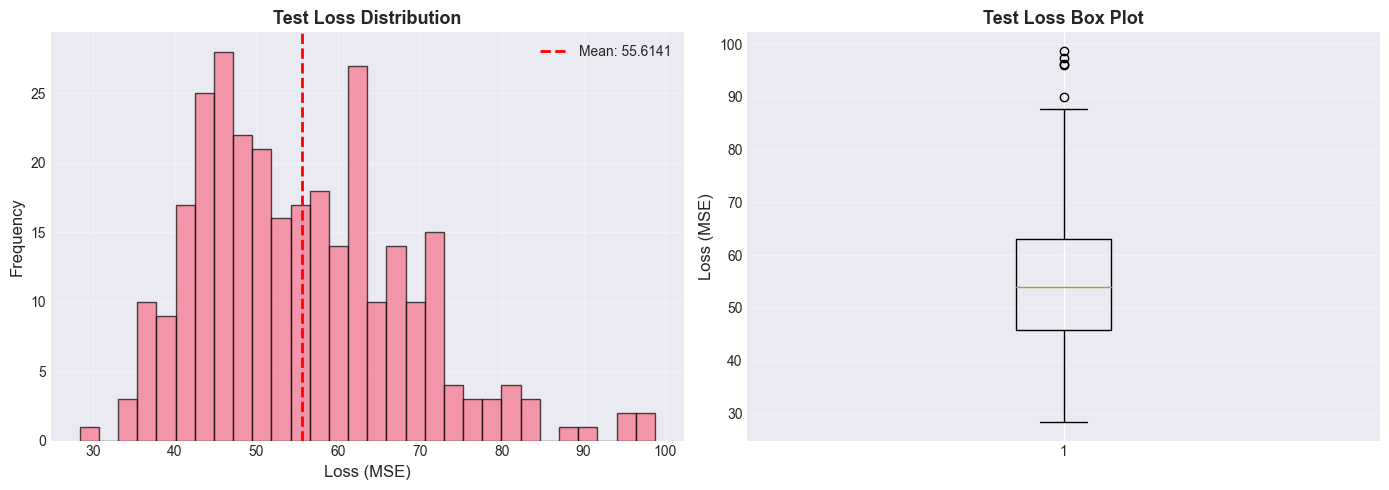

In [26]:
# Test loss distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(test_losses, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(avg_test_loss, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {avg_test_loss:.4f}')
axes[0].set_xlabel('Loss (MSE)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Test Loss Distribution', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(test_losses, vert=True)
axes[1].set_ylabel('Loss (MSE)', fontsize=12)
axes[1].set_title('Test Loss Box Plot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
chart_path = Config.CHARTS_DIR / 'test_loss_distribution.png'
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
print(f"✓ Test loss distribution saved to {chart_path}")
plt.show()

## 6. Model Persistence and Summary

In [27]:
# Create comprehensive model summary
summary = {
    'project': 'Azerbaijani TTS Model',
    'timestamp': datetime.now().isoformat(),
    'dataset': {
        'total_samples': len(df),
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'sample_rate': Config.SAMPLE_RATE,
        'n_mels': Config.N_MELS
    },
    'model': {
        'architecture': 'Seq2Seq with Attention',
        'total_parameters': total_params,
        'vocab_size': char_encoder.vocab_size,
        'device': str(Config.DEVICE)
    },
    'training': {
        'epochs_trained': len(train_losses),
        'batch_size': Config.BATCH_SIZE,
        'learning_rate': Config.LEARNING_RATE,
        'best_epoch': checkpoint['epoch'] + 1,
        'best_val_loss': float(checkpoint['val_loss']),
        'final_train_loss': float(train_losses[-1]),
        'final_val_loss': float(val_losses[-1])
    },
    'evaluation': {
        'test_loss_mean': float(avg_test_loss),
        'test_loss_std': float(std_test_loss),
        'test_loss_min': float(min(test_losses)),
        'test_loss_max': float(max(test_losses))
    },
    'artifacts': {
        'best_model': str(Config.ARTIFACTS_DIR / 'best_model.pt'),
        'final_model': str(Config.ARTIFACTS_DIR / 'final_model.pt'),
        'char_encoder': str(Config.ARTIFACTS_DIR / 'char_encoder.pkl')
    }
}

# Save summary
with open(Config.OUTPUTS_DIR / 'model_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("="*80)
print("MODEL TRAINING SUMMARY")
print("="*80)
print(json.dumps(summary, indent=2))
print("\n" + "="*80)
print(f"✓ Summary saved to {Config.OUTPUTS_DIR / 'model_summary.json'}")

MODEL TRAINING SUMMARY
{
  "project": "Azerbaijani TTS Model",
  "timestamp": "2026-01-04T16:49:31.873186",
  "dataset": {
    "total_samples": 2000,
    "train_samples": 1400,
    "val_samples": 300,
    "test_samples": 300,
    "sample_rate": 16000,
    "n_mels": 80
  },
  "model": {
    "architecture": "Seq2Seq with Attention",
    "total_parameters": 7200209,
    "vocab_size": 124,
    "device": "cpu"
  },
  "training": {
    "epochs_trained": 28,
    "batch_size": 8,
    "learning_rate": 0.001,
    "best_epoch": 27,
    "best_val_loss": 36.228043606406764,
    "final_train_loss": 36.86119627816336,
    "final_val_loss": 36.23918774253443
  },
  "evaluation": {
    "test_loss_mean": 55.61408972422282,
    "test_loss_std": 12.653016342858223,
    "test_loss_min": 28.387920379638672,
    "test_loss_max": 98.71955871582031
  },
  "artifacts": {
    "best_model": "artifacts/best_model.pt",
    "final_model": "artifacts/final_model.pt",
    "char_encoder": "artifacts/char_encoder.pkl"
 

In [28]:
# List all generated artifacts
print("\n" + "="*80)
print("GENERATED ARTIFACTS")
print("="*80)

print("\nCharts:")
for chart in sorted(Config.CHARTS_DIR.glob('*.png')):
    print(f"  - {chart.name}")

print("\nOutputs:")
for output in sorted(Config.OUTPUTS_DIR.glob('*')):
    print(f"  - {output.name}")

print("\nModel Artifacts:")
for artifact in sorted(Config.ARTIFACTS_DIR.glob('*')):
    size_mb = artifact.stat().st_size / (1024 * 1024)
    print(f"  - {artifact.name} ({size_mb:.2f} MB)")

print("\n" + "="*80)
print("✓ Training pipeline completed successfully!")
print("="*80)


GENERATED ARTIFACTS

Charts:
  - data_exploration.png
  - predictions_comparison.png
  - sample_mel_spectrograms.png
  - test_loss_distribution.png
  - training_curves.png

Outputs:
  - config.json
  - data_split.json
  - dataset_overview.json
  - model_info.json
  - model_summary.json
  - sample_texts.csv
  - test_metrics.json
  - text_statistics.csv
  - training_history.csv

Model Artifacts:
  - .gitkeep (0.00 MB)
  - best_model.pt (82.44 MB)
  - char_encoder.pkl (0.00 MB)
  - final_model.pt (82.44 MB)

✓ Training pipeline completed successfully!


## 7. Inference Example

Synthesizing: 'Salam, mən Python dilini öyrənirəm.'
✓ Synthesis complete
  - Output shape: (80, 500)

✓ Synthesis example saved to charts/synthesis_example.png


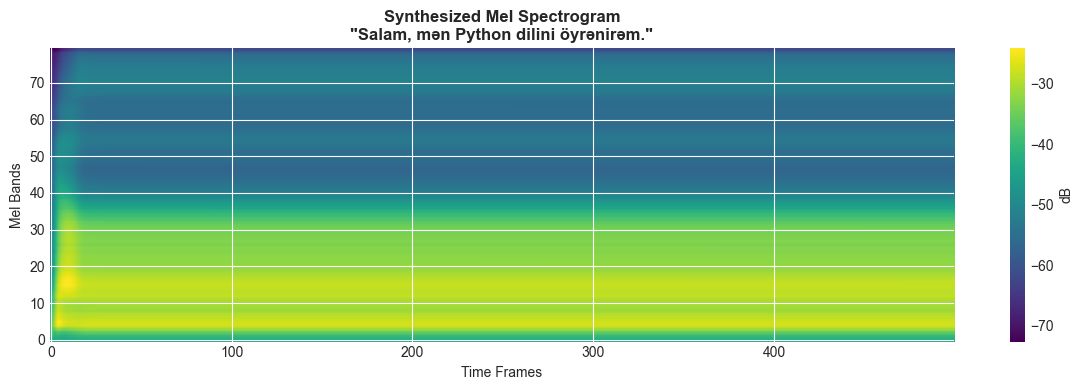

In [29]:
# Inference function
def synthesize_speech(text, model, char_encoder, device, max_len=500):
    """
    Synthesize speech from text.
    
    Args:
        text: Input text string
        model: Trained TTS model
        char_encoder: Character encoder
        device: Device to run inference on
        max_len: Maximum mel spectrogram length
        
    Returns:
        Mel spectrogram (numpy array)
    """
    model.eval()
    
    # Encode text
    text_encoded = char_encoder.encode(text, max_length=Config.MAX_TEXT_LENGTH)
    text_tensor = torch.tensor([text_encoded], dtype=torch.long).to(device)
    
    # Generate mel spectrogram
    with torch.no_grad():
        mel_output = model(text_tensor, mel_target=None, max_len=max_len)
    
    # Convert to numpy
    mel_numpy = mel_output.cpu().numpy()[0]
    
    return mel_numpy

# Test synthesis
test_text = "Salam, mən Python dilini öyrənirəm."
print(f"Synthesizing: '{test_text}'")

synthesized_mel = synthesize_speech(test_text, model, char_encoder, Config.DEVICE)

print(f"✓ Synthesis complete")
print(f"  - Output shape: {synthesized_mel.shape}")

# Visualize
plt.figure(figsize=(12, 4))
plt.imshow(synthesized_mel, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='dB')
plt.xlabel('Time Frames')
plt.ylabel('Mel Bands')
plt.title(f'Synthesized Mel Spectrogram\n"{test_text}"', fontweight='bold')
plt.tight_layout()

chart_path = Config.CHARTS_DIR / 'synthesis_example.png'
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Synthesis example saved to {chart_path}")
plt.show()

## Conclusion

This notebook has successfully implemented an end-to-end TTS training pipeline:

1. **Data Loading**: Loaded and explored a subset of the Azerbaijani ASR dataset
2. **Preprocessing**: Implemented character encoding and mel-spectrogram extraction
3. **Model Training**: Trained a lightweight Seq2Seq TTS model with attention
4. **Evaluation**: Evaluated model performance on test set
5. **Persistence**: Saved all models, encoders, and results

### Next Steps

To improve the model:
- Train on more data (increase `SAMPLE_SIZE` if hardware allows)
- Implement a vocoder (e.g., WaveGlow, HiFi-GAN) to convert mel spectrograms to audio
- Add data augmentation techniques
- Experiment with different architectures (Tacotron 2, FastSpeech)
- Fine-tune hyperparameters

### Reproducibility

All random seeds are fixed and configuration is saved. To reproduce:
1. Load the same configuration from `outputs/config.json`
2. Use the saved character encoder from `artifacts/char_encoder.pkl`
3. Load the best model from `artifacts/best_model.pt`